In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import os

In [2]:
class FLI_Prior:
    def __init__(self):
        self.tau1_mean_hyperprior_mean = np.log(0.2)
        self.tau1_mean_hyperprior_std = 0.7
        self.tau1_std_hyperprior_mean = -1
        self.tau1_std_hyperprior_std = 0.1

        self.delta_tau_mean_hyperprior_mean = np.log(1.2)
        self.delta_tau_mean_hyperprior_std = 0.5
        self.delta_tau_std_hyperprior_mean = -2
        self.delta_tau_std_hyperprior_std = 0.1

        self.alpha_hyperprior_a = 1
        self.alpha_hyperprior_b = 1
        self.beta_hyperprior_a = 1
        self.beta_hyperprior_b = 1

        self.sample_global()

    def sample_global(self):
        self.log_tau_G = np.random.normal(self.tau1_mean_hyperprior_mean, self.tau1_mean_hyperprior_std)
        self.log_sigma_tau_G = np.random.normal(self.tau1_std_hyperprior_mean, self.tau1_std_hyperprior_std)

        self.log_delta_tau_G = np.random.normal(self.delta_tau_mean_hyperprior_mean, self.delta_tau_mean_hyperprior_std)
        self.log_delta_sigma_tau_G = np.random.normal(self.delta_tau_std_hyperprior_mean, self.delta_tau_std_hyperprior_std)

#         self.alpha_hyperprior = np.random.gamma(self.alpha_hyperprior_a, self.alpha_hyperprior_b)
#         self.beta_hyperprior = np.random.gamma(self.beta_hyperprior_a, self.beta_hyperprior_b)
        
        self.alpha_hyperprior = np.random.normal(-1, 1)
        self.beta_hyperprior = np.random.normal(0, 0.1)

        return dict(log_tau_G=self.log_tau_G, log_sigma_tau_G=self.log_sigma_tau_G,
                    log_delta_tau_G=self.log_delta_tau_G, log_delta_sigma_tau_G=self.log_delta_sigma_tau_G,
                    alpha_hyperprior=self.alpha_hyperprior, beta_hyperprior=self.beta_hyperprior,
                    log_alpha_hyperprior=np.log(self.alpha_hyperprior), log_beta_hyperprior=np.log(self.beta_hyperprior))

    def get_local_variances(self):
        var_tau_L = np.exp(2 * self.log_tau_G + np.exp(self.log_sigma_tau_G)**2) * (np.exp(np.exp(self.log_sigma_tau_G)**2) - 1)
        var_delta = np.exp(2 * self.log_delta_tau_G + np.exp(self.log_delta_sigma_tau_G)**2) * (np.exp(np.exp(self.log_delta_sigma_tau_G)**2) - 1)
        tau_L1_std = np.sqrt(var_tau_L)
        tau_L2_std = np.sqrt(var_tau_L + var_delta)
        return dict(tau_L1_std=tau_L1_std, tau_L2_std=tau_L2_std)


    def sample_local(self, n_local_samples):
        log_tau_L = np.random.normal(self.log_tau_G, np.exp(self.log_sigma_tau_G), size=n_local_samples)
        log_delta_tau_L = np.random.normal(self.log_delta_tau_G, np.exp(self.log_delta_sigma_tau_G), size=n_local_samples)
        #A_L = np.random.beta(self.alpha_hyperprior, self.beta_hyperprior, size=n_local_samples)
        a_l = np.random.normal(self.alpha_hyperprior, np.exp(self.beta_hyperprior), size=n_local_samples)

        tau_L = np.exp(log_tau_L)
        tau_L_2 = tau_L + np.exp(log_delta_tau_L)
        #a_l = np.log(A_L / (1 - A_L + 1e-8))
        import scipy
        A_L = scipy.special.expit(a_l)
        return dict(tau_L=tau_L, tau_L_2=tau_L_2, A_L=A_L,
                    log_tau_L=log_tau_L, log_delta_tau_L=log_delta_tau_L, a_l=a_l)


/var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/ipykernel_51988/3928932884.py:36: RuntimeWarning: invalid value encountered in log
  log_alpha_hyperprior=np.log(self.alpha_hyperprior), log_beta_hyperprior=np.log(self.beta_hyperprior))


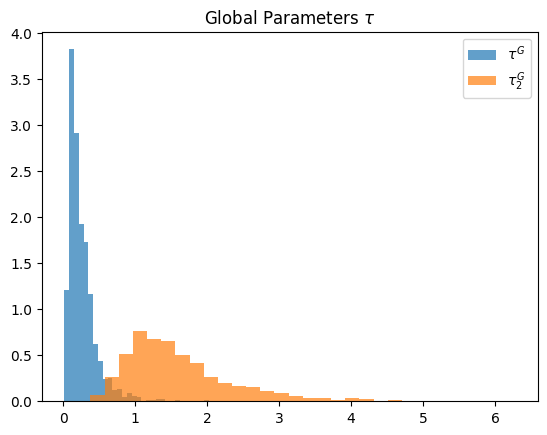

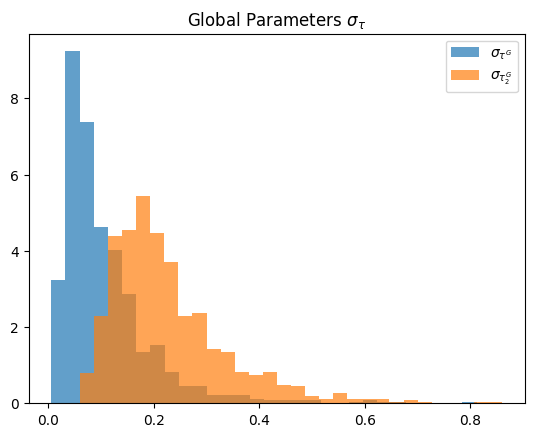

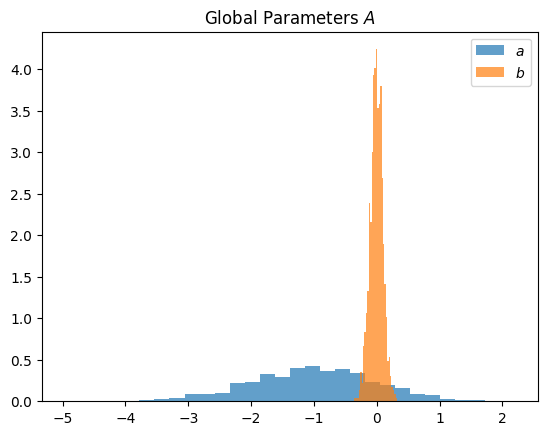

/var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/ipykernel_51988/326551330.py:58: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(alpha_hyperprior), bins=30, alpha=0.7, density=True, label=r'$\log a$')
/var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/ipykernel_51988/326551330.py:59: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(beta_hyperprior), bins=30, alpha=0.7, density=True, label=r'$\log b$')


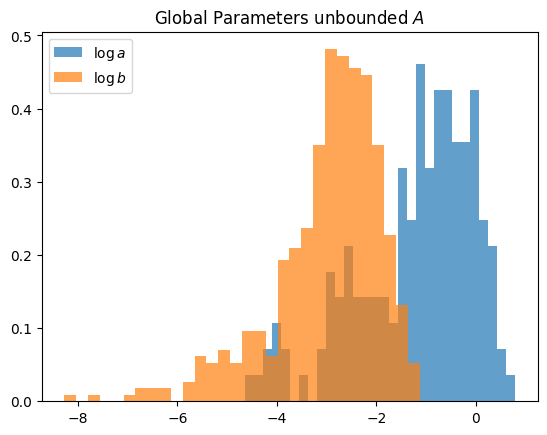

In [3]:
# distribution
n_global_samples = 1000

prior = FLI_Prior()

log_tau_G = []
log_sigma_tau_G = []
log_delta_tau_G = []
log_delta_sigma_tau_G = []
alpha_hyperprior = []
beta_hyperprior = []
tau_L1_std = []
tau_L2_std = []

for i in range(n_global_samples):
    sample = prior.sample_global()
    log_tau_G.append(sample['log_tau_G'])
    log_sigma_tau_G.append(sample['log_sigma_tau_G'])
    log_delta_tau_G.append(sample['log_delta_tau_G'])
    log_delta_sigma_tau_G.append(sample['log_delta_sigma_tau_G'])
    alpha_hyperprior.append(sample['alpha_hyperprior'])
    beta_hyperprior.append(sample['beta_hyperprior'])
    tau_std = prior.get_local_variances()
    tau_L1_std.append(tau_std['tau_L1_std'])
    tau_L2_std.append(tau_std['tau_L2_std'])
log_tau_G = np.array(log_tau_G)
log_sigma_tau_G = np.array(log_sigma_tau_G)
log_delta_tau_G = np.array(log_delta_tau_G)
log_delta_sigma_tau_G = np.array(log_delta_sigma_tau_G)
alpha_hyperprior = np.array(alpha_hyperprior)
beta_hyperprior = np.array(beta_hyperprior)
tau_L1_std = np.array(tau_L1_std)
tau_L2_std = np.array(tau_L2_std)


tau_G = np.exp(log_tau_G)
tau_G2 = tau_G + np.exp(log_delta_tau_G)

plt.title(r'Global Parameters $\tau$')
plt.hist(tau_G, bins=30, alpha=0.7, density=True, label=r'$\tau^G$')
plt.hist(tau_G2, bins=30, alpha=0.7, density=True, label=r'$\tau^G_2$')
plt.legend()
plt.show()

plt.title(r'Global Parameters $\sigma_{\tau}$')
plt.hist(tau_L1_std, bins=30, alpha=0.7, density=True, label=r'$\sigma_{\tau^G}$')
plt.hist(tau_L2_std, bins=30, alpha=0.7, density=True, label=r'$\sigma_{\tau^G_2}$')
plt.legend()
plt.show()

plt.title(r'Global Parameters $A$')
plt.hist(alpha_hyperprior, bins=30, alpha=0.7, density=True, label=r'$a$')
plt.hist(beta_hyperprior, bins=30, alpha=0.7, density=True, label=r'$b$')
plt.legend()
plt.show()

plt.title(r'Global Parameters unbounded $A$')
plt.hist(np.log(alpha_hyperprior), bins=30, alpha=0.7, density=True, label=r'$\log a$')
plt.hist(np.log(beta_hyperprior), bins=30, alpha=0.7, density=True, label=r'$\log b$')
plt.legend()
plt.show()

/var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/ipykernel_51988/3928932884.py:36: RuntimeWarning: invalid value encountered in log
  log_alpha_hyperprior=np.log(self.alpha_hyperprior), log_beta_hyperprior=np.log(self.beta_hyperprior))


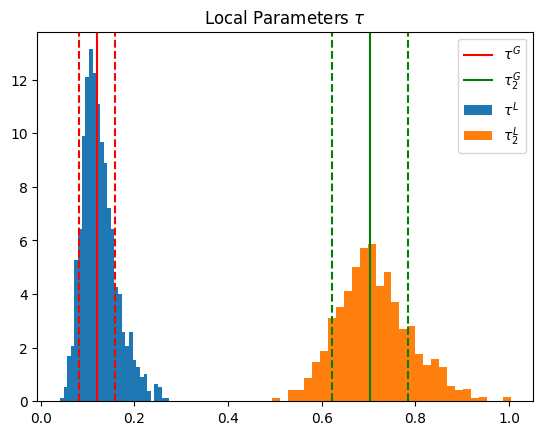

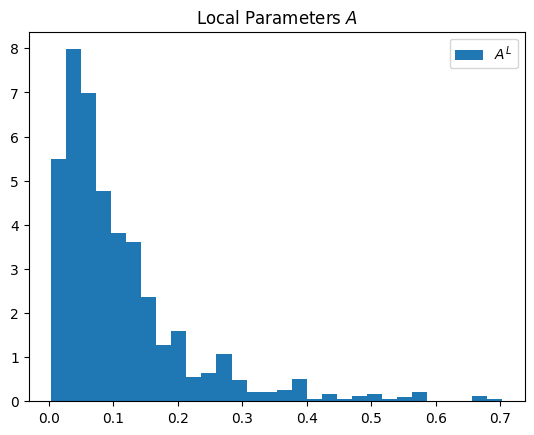

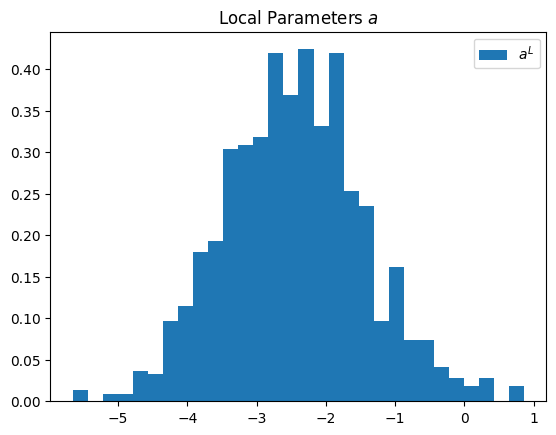

In [4]:
global_sample = prior.sample_global()
local_samples = prior.sample_local(1000)
tau_std = prior.get_local_variances()
tau_L1_std = tau_std['tau_L1_std']
tau_L2_std = tau_std['tau_L2_std']

tau_L = local_samples['tau_L']
tau_L_2 = local_samples['tau_L_2']
log_delta_tau_L = local_samples['log_delta_tau_L']
A_L = local_samples['A_L']
a_l = local_samples['a_l']

tau_G = np.exp(global_sample['log_tau_G'])
tau_G2 = tau_G + np.exp(global_sample['log_delta_tau_G'])

plt.title(r'Local Parameters $\tau$')
plt.axvline(tau_G, color='red', linestyle='-', label=r'$\tau^G$')
plt.axvline(tau_G-tau_L1_std, color='red', linestyle='--')
plt.axvline(tau_G+tau_L1_std, color='red', linestyle='--')
plt.axvline(tau_G2, color='green', linestyle='-', label=r'$\tau^G_2$')
plt.axvline(tau_G2-tau_L2_std, color='green', linestyle='--')
plt.axvline(tau_G2+tau_L2_std, color='green', linestyle='--')
plt.hist(tau_L, bins=30, density=True, label=r'$\tau^L$')
plt.hist(tau_L_2, bins=30, density=True, label=r'$\tau^L_2$')
plt.legend()
plt.show()

plt.title(r'Local Parameters $A$')
plt.hist(A_L, bins=30, density=True, label=r'$A^L$')
plt.legend()
plt.show()

plt.title(r'Local Parameters $a$')
plt.hist(a_l, bins=30, density=True, label=r'$a^L$')
plt.legend()
plt.show()

In [5]:
def decay_gen(img, irf, noise, gw, n_local_samples):  # IRF, Gate_width (in ps)
    a, b = np.shape(img)
    a1, b1, c1 = np.shape(irf)
    a2, b2, c2 = np.shape(noise)
    t = np.linspace(0, c1* (gw  * (10 ** -3)), c1)
    t_minus = np.multiply(t, -1)
    #tau_L, tau_L_2, A_L = pram1.generate_local_parameters(n_local_samples)
    prior_samples = prior.sample_local(n_local_samples)
    tau_L, tau_L_2, A_L = prior_samples['tau_L'], prior_samples['tau_L_2'], prior_samples['A_L']
    tau1 = np.reshape(tau_L, (a, b))
    tau2 = np.reshape(tau_L_2, (a, b))
    frac1 = np.reshape(A_L, (a, b))
    frac2 = 1 - frac1
    dec = np.zeros([c1])
    A = np.zeros([c1])
    B = np.zeros([c1])
    irf_out = np.zeros([c1])
    dec_conv =  np.zeros([c1])
    i = np.random.randint(a)
    j = np.random.randint(b)
    if tau1[i, j] != 0:               
        A = np.multiply(frac1[i, j], np.exp(np.divide(t_minus, tau1[i, j])))
    if tau2[i, j] != 0:
        B = np.multiply(frac2[i, j], np.exp(np.divide(t_minus, tau2[i, j])))
    dec = A + B
    irf_out = norm1D(irf[i,j, :])
    dec_conv = conv_dec(norm1D(dec), irf_out)
    dec_conv = norm1D(np.squeeze(dec_conv))*img[i,j]           
    dec_conv += noise[i,j,:] 
    return dec_conv, tau1[i, j], tau2[i, j], frac1[i, j]

def tiff2tpsfs(p):
    k = os.listdir(p)
    le = len(k)
    img0 = mpimg.imread(os.path.join(p, k[0]))
    (a, b) = np.shape(img0)
    tpsfs = np.zeros([a, b, le - 1])
    for count, file in enumerate(os.listdir(p)):
        # Check whether file is in text format or not
        if file.endswith(".tif"):
            imt = mpimg.imread(os.path.join(p, file))
            tpsfs[:, :, count] = imt
    inten = np.sum(tpsfs, axis=2)
    return tpsfs, inten

def norm1D(fn):
    if np.amax(fn) == 0:
        nfn = fn
    else:
        nfn = np.divide(fn, np.amax(fn))
    return nfn

def conv_dec(dec, irf):
    c = np.shape(dec)
#     conv = np.zeros((2 * c - 1,1))
    conv = np.convolve(dec, irf)
    conv = conv[:len(dec)]
    return conv

def random_crop(array, crop_size):
    A, B, C = array.shape
    a, b = crop_size
    
    if a > A or b > B:
        raise ValueError("Crop size must be smaller than or equal to the original array size")
    
    # Randomly select the top-left corner of the crop
    top = np.random.randint(0, A - a + 1)
    left = np.random.randint(0, B - b + 1)
    
    # Crop the subarray
    return array[top:top + a, left:left + b, :]

In [6]:
ns = np.load('system_noise.npy')
pIRF = np.load('IRF.npy')

(520, 696, 201)


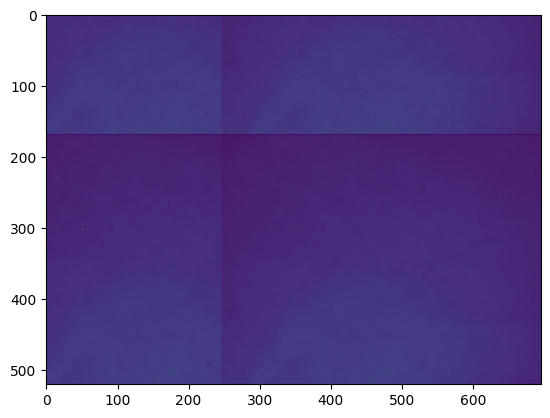

366
340


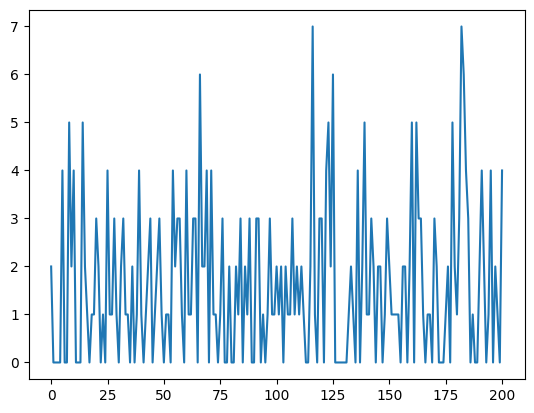

In [7]:
print(pIRF.shape)
plt.imshow(np.sum(pIRF, axis=2))
plt.show()
a = np.random.randint(ns.shape[0])
b = np.random.randint(ns.shape[1])
print(a)
print(b)
plt.plot(ns[a,b,:])
plt.show()

### For Data generation

In [16]:
gw = 40
data_size = 5000
img_size = (8, 8)
sub_pIRF = random_crop(pIRF, img_size)
# global parameters
F_log_tau_G = np.zeros((data_size, 1))
F_log_sigma_tau_G = np.zeros((data_size, 1))
F_log_Delta_tau_G = np.zeros((data_size, 1))
F_log_Delta_sigma_tau_G = np.zeros((data_size, 1))
F_log_a = np.zeros((data_size, 1))
F_log_b = np.zeros((data_size, 1))

# data and local parameters
F_dec_conv = np.zeros((data_size, pIRF.shape[2]))
F_tau1 = np.zeros((data_size, 1))
F_tau2 = np.zeros((data_size, 1))
F_frac1 = np.zeros((data_size, 1))

for i in range(data_size):
    global_sample = prior.sample_global()
    F_log_tau_G[i], F_log_sigma_tau_G[i], F_log_Delta_tau_G[i], F_log_Delta_sigma_tau_G[i], F_log_a[i], F_log_b[i] = global_sample['log_tau_G'], global_sample['log_sigma_tau_G'], global_sample['log_delta_tau_G'], global_sample['log_delta_sigma_tau_G'], global_sample['log_alpha_hyperprior'], global_sample['log_beta_hyperprior']
    img = np.random.randint(0, high=1000, size=(img_size[0], img_size[1]))
    F_dec_conv[i], F_tau1[i], F_tau2[i], F_frac1[i] = decay_gen(img, pIRF, ns, gw, n_local_samples=img_size[0]*img_size[1])


/var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/ipykernel_51988/3928932884.py:36: RuntimeWarning: invalid value encountered in log
  log_alpha_hyperprior=np.log(self.alpha_hyperprior), log_beta_hyperprior=np.log(self.beta_hyperprior))


In [17]:
F_log_tau_G

array([[-0.97338023],
       [-3.21301166],
       [-1.09606254],
       ...,
       [-2.19880114],
       [-0.49747795],
       [-1.95533067]])

In [18]:
F_dec_conv.shape

(5000, 201)

4650
0.5463761015843127
1.6004242150434012
0.07312224295103006


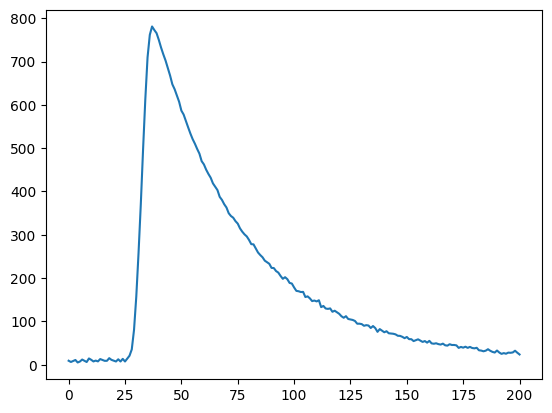

In [19]:
x=np.random.randint(data_size)
print(x)
print(F_tau1[x,0])
print(F_tau2[x,0])
print(F_frac1[x,0])
data = F_dec_conv[x,:]
plt.plot(data[:])
plt.show()

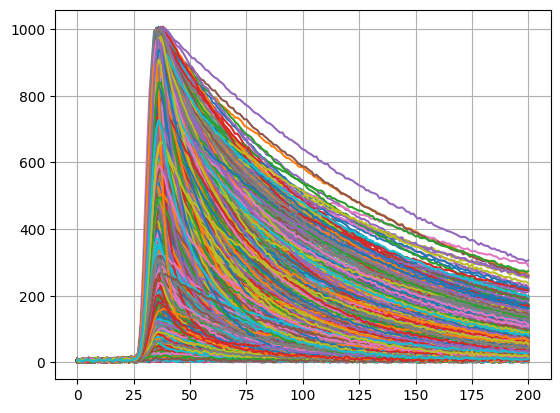

In [20]:
plt.figure()
for i in range(F_dec_conv.shape[0]):
   
    slice_data = F_dec_conv[i, :]  # Extract the data along axis 3 for (i, j)

    plt.plot( F_dec_conv[i, :]) # plot the 201 values

    plt.grid(True)
plt.show()